# Global Terrorist Attacks

Global Terrorism Database (GTD) is an open-source database including information on terrorist events around the world from 1970 through 2014. Some portion of the attacks have not been attributed to a particular terrorist group.

Use attack type, weapons used, description of the attack, etc. to build a model that can predict what group may have been responsible for an incident. 

We will start by updating and installing some of the libraries in this runtime.

In [1]:
!pip install -U seaborn
!pip install xlrd>=0.9.0
!pip install pdpbox
!pip install eli5

Requirement already up-to-date: seaborn in /Users/mostafagazar/anaconda3/envs/tf/lib/python3.5/site-packages
Requirement already up-to-date: matplotlib>=1.4.3 in /Users/mostafagazar/anaconda3/envs/tf/lib/python3.5/site-packages (from seaborn)
Requirement already up-to-date: pandas>=0.15.2 in /Users/mostafagazar/anaconda3/envs/tf/lib/python3.5/site-packages (from seaborn)
Requirement already up-to-date: numpy>=1.9.3 in /Users/mostafagazar/anaconda3/envs/tf/lib/python3.5/site-packages (from seaborn)
Requirement already up-to-date: scipy>=0.14.0 in /Users/mostafagazar/anaconda3/envs/tf/lib/python3.5/site-packages (from seaborn)
Requirement already up-to-date: pyparsing!=2.0.4,!=2.1.2,!=2.1.6,>=2.0.1 in /Users/mostafagazar/anaconda3/envs/tf/lib/python3.5/site-packages (from matplotlib>=1.4.3->seaborn)
Requirement already up-to-date: python-dateutil>=2.1 in /Users/mostafagazar/anaconda3/envs/tf/lib/python3.5/site-packages (from matplotlib>=1.4.3->seaborn)
Requirement already up-to-date: kiw

In [2]:
import os.path

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Download dataset

I will first explore a small dataset (attacks between 2014-2017) and then re-run all the cells on the complete dataset.

In [3]:
# excel_file = "gtd_14to17_0718dist.xlsx"
excel_file = "globalterrorismdb_0718dist.xlsx"

if os.path.isfile(excel_file):
    print("Reading local", excel_file)
    df = pd.read_excel(excel_file)
else:
    print("Downloading and reading,", excel_file)
    df = pd.read_excel('http://apps.start.umd.edu/gtd/downloads/dataset/' + excel_file)

Reading local globalterrorismdb_0718dist.xlsx


In [4]:
df.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaT,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaT,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaT,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaT,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaT,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [5]:
df.columns.tolist()

['eventid',
 'iyear',
 'imonth',
 'iday',
 'approxdate',
 'extended',
 'resolution',
 'country',
 'country_txt',
 'region',
 'region_txt',
 'provstate',
 'city',
 'latitude',
 'longitude',
 'specificity',
 'vicinity',
 'location',
 'summary',
 'crit1',
 'crit2',
 'crit3',
 'doubtterr',
 'alternative',
 'alternative_txt',
 'multiple',
 'success',
 'suicide',
 'attacktype1',
 'attacktype1_txt',
 'attacktype2',
 'attacktype2_txt',
 'attacktype3',
 'attacktype3_txt',
 'targtype1',
 'targtype1_txt',
 'targsubtype1',
 'targsubtype1_txt',
 'corp1',
 'target1',
 'natlty1',
 'natlty1_txt',
 'targtype2',
 'targtype2_txt',
 'targsubtype2',
 'targsubtype2_txt',
 'corp2',
 'target2',
 'natlty2',
 'natlty2_txt',
 'targtype3',
 'targtype3_txt',
 'targsubtype3',
 'targsubtype3_txt',
 'corp3',
 'target3',
 'natlty3',
 'natlty3_txt',
 'gname',
 'gsubname',
 'gname2',
 'gsubname2',
 'gname3',
 'gsubname3',
 'motive',
 'guncertain1',
 'guncertain2',
 'guncertain3',
 'individual',
 'nperps',
 'nperpcap',
 

Looking at the above columns, I suspect that:
* Region/country would a great factor in predicting what group may be responsible for an attack.
* Date would also be a good factor
* Weapon and target as well

We will find out later if these assumptions are correct or not by doing permutation importance on my trained models.

## Clean data

Next step is assesing our data and do some data cleanup

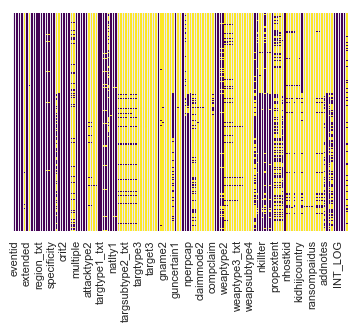

In [6]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

### Drop almost empty columns

I will start by dropping all the columns that are almost empty (70% empty)


In [7]:
DROP_THRESHOLD = .70

columns_to_drop = []
for column in df.columns.tolist():
    null_ratio = df[column].isnull().sum() / len(df[column])
    if null_ratio > DROP_THRESHOLD:
        columns_to_drop.append(column)
        print (column, "with null ratio", null_ratio , "will be dropped")

df.drop(columns_to_drop, axis=1, inplace=True)

approxdate with null ratio 0.9491499303762982 will be dropped
resolution with null ratio 0.9877814531264619 will be dropped
alternative with null ratio 0.8403278093026072 will be dropped
alternative_txt with null ratio 0.8403278093026072 will be dropped
attacktype2 with null ratio 0.9652486914596761 will be dropped
attacktype2_txt with null ratio 0.9652486914596761 will be dropped
attacktype3 with null ratio 0.997644352224381 will be dropped
attacktype3_txt with null ratio 0.997644352224381 will be dropped
targtype2 with null ratio 0.9386650962348162 will be dropped
targtype2_txt with null ratio 0.9386650962348162 will be dropped
targsubtype2 with null ratio 0.9411913633586694 will be dropped
targsubtype2_txt with null ratio 0.9411913633586694 will be dropped
corp2 with null ratio 0.9443175501263134 will be dropped
target2 with null ratio 0.9393475736277526 will be dropped
natlty2 with null ratio 0.9404043128168154 will be dropped
natlty2_txt with null ratio 0.9404043128168154 will be 

### Drop almost empty rows

Rows with invalid data like when the attack group is unkown will be of much help, it will just confuse the model.

In [8]:
print("All attacks", len(df))

# Also drop rows where gname is unkown
df = df[df['gname'] != 'Unknown']

print("Attacks where the attack group was known", len(df))

All attacks 181691
Attacks where the attack group was known 98909


In [9]:
df.head()

,eventid,iyear,imonth,iday,extended,country,country_txt,region,region_txt,provstate,...,propcomment,ishostkid,ransom,scite1,scite2,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY
0,197000000001,1970,7,2,0,58,Dominican Republic,2,Central America & Caribbean,NaN,...,NaN,0.0,0.0,NaN,NaN,PGIS,0,0,0,0
1,197000000002,1970,0,0,0,130,Mexico,1,North America,Federal,...,NaN,1.0,1.0,NaN,NaN,PGIS,0,1,1,1
5,197001010002,1970,1,1,0,217,United States,1,North America,Illinois,...,NaN,0.0,0.0,"""Police Chief Quits,"" Washington Post, January...","""Cairo Police Chief Quits; Decries Local 'Mili...",Hewitt Project,-9,-9,0,-9
6,197001020001,1970,1,2,0,218,Uruguay,3,South America,Montevideo,...,NaN,0.0,0.0,NaN,NaN,PGIS,0,0,0,0
8,197001020003,1970,1,2,0,217,United States,1,North America,Wisconsin,...,"Basketball courts, weight room, swimming pool,...",0.0,0.0,"Tom Bates, ""Rads: The 1970 Bombing of the Army...","David Newman, Sandra Sutherland, and Jon Stewa...",Hewitt Project,0,0,0,0


In [10]:
df.columns.tolist()

['eventid',
 'iyear',
 'imonth',
 'iday',
 'extended',
 'country',
 'country_txt',
 'region',
 'region_txt',
 'provstate',
 'city',
 'latitude',
 'longitude',
 'specificity',
 'vicinity',
 'location',
 'summary',
 'crit1',
 'crit2',
 'crit3',
 'doubtterr',
 'multiple',
 'success',
 'suicide',
 'attacktype1',
 'attacktype1_txt',
 'targtype1',
 'targtype1_txt',
 'targsubtype1',
 'targsubtype1_txt',
 'corp1',
 'target1',
 'natlty1',
 'natlty1_txt',
 'gname',
 'guncertain1',
 'individual',
 'nperps',
 'nperpcap',
 'claimed',
 'weaptype1',
 'weaptype1_txt',
 'weapsubtype1',
 'weapsubtype1_txt',
 'weapdetail',
 'nkill',
 'nkillus',
 'nkillter',
 'nwound',
 'nwoundus',
 'nwoundte',
 'property',
 'propextent',
 'propextent_txt',
 'propcomment',
 'ishostkid',
 'ransom',
 'scite1',
 'scite2',
 'dbsource',
 'INT_LOG',
 'INT_IDEO',
 'INT_MISC',
 'INT_ANY']

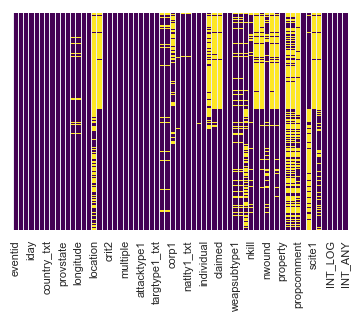

In [11]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

That's looking a little better, next will just fill the unavailable data

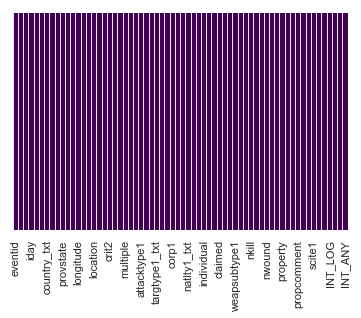

In [12]:
df.fillna(0, inplace=True)

sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

## Data exploration

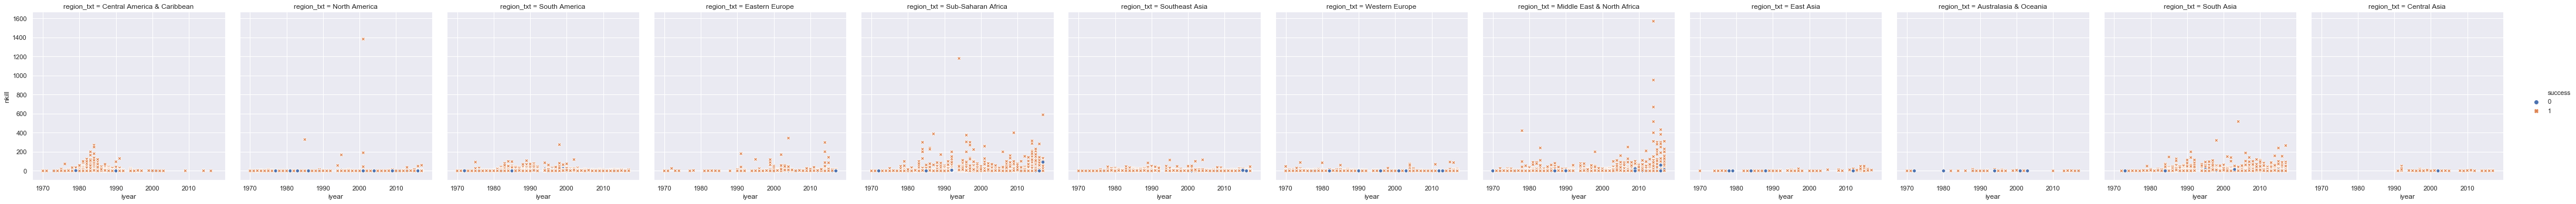

In [13]:
sns.relplot(x="iyear", y="nkill", 
            col="region_txt", # Categorical variables that will determine the faceting of the grid.
            hue="success",  # Grouping variable that will produce elements with different colors.
            style="success", # Grouping variable that will produce elements with different styles.
            data=df)

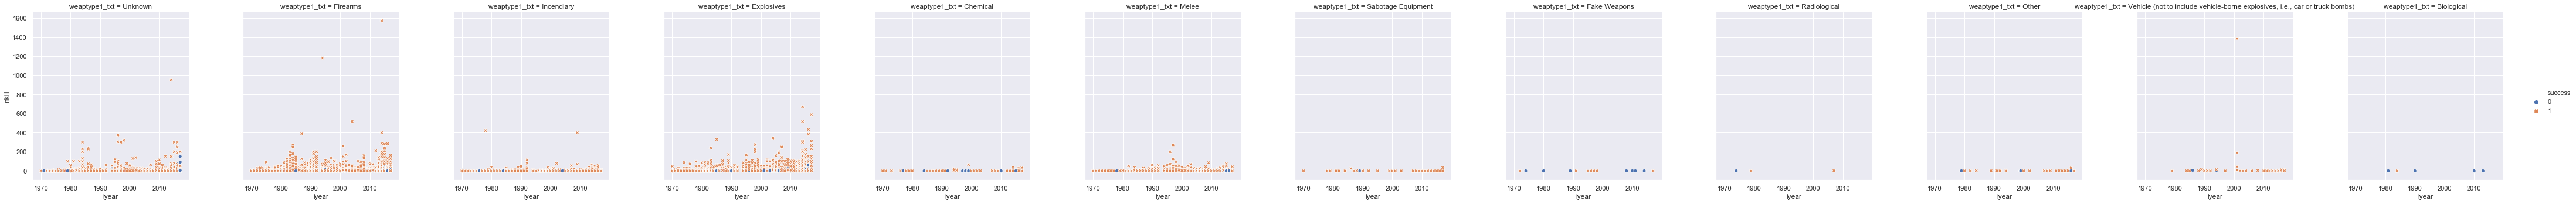

In [14]:
sns.relplot(x="iyear", y="nkill", 
           col="weaptype1_txt", # Categorical variables that will determine the faceting of the grid.
           hue="success",  # Grouping variable that will produce elements with different colors.
           style="success", # Grouping variable that will produce elements with different styles.
           data=df)

Number of attacks by group

In [15]:
df.groupby("gname").size().sort_values(ascending=False).head()

gname
Taliban                                             7478
Islamic State of Iraq and the Levant (ISIL)         5613
Shining Path (SL)                                   4555
Farabundo Marti National Liberation Front (FMLN)    3351
Al-Shabaab                                          3288
dtype: int64

Number of kills by group

In [16]:
df.groupby("gname")["nkill"].sum().sort_values(ascending=False).head()

gname
Islamic State of Iraq and the Levant (ISIL)    38923.0
Taliban                                        29410.0
Boko Haram                                     20328.0
Shining Path (SL)                              11601.0
Liberation Tigers of Tamil Eelam (LTTE)        10989.0
Name: nkill, dtype: float64

Number of attacks by target

In [17]:
df.groupby("targtype1_txt").size().sort_values(ascending=False).head()

targtype1_txt
Private Citizens & Property    22727
Military                       18969
Police                         14094
Business                       11518
Government (General)            9946
dtype: int64

Number of attacks by nationality

In [18]:
df.groupby("natlty1_txt").size().sort_values(ascending=False).head()

natlty1_txt
India          7805
Afghanistan    6989
Iraq           6010
Colombia       5958
Peru           4994
dtype: int64

Looking at the numbers above that might indicate that people with certain nationalities might be more likely to commit terrorist attacks but is that actually true?

In [19]:
df.groupby(['country_txt', 'natlty1_txt']).size()

country_txt  natlty1_txt             
Afghanistan  0                            259
             Afghanistan                 6938
             Algeria                        1
             Asian                          3
             Australia                      2
             Bangladesh                     3
             Canada                         7
             China                          3
             Denmark                        1
             France                         8
             Germany                        7
             Great Britain                  8
             Iceland                        1
             India                         20
             International                522
             Iran                           4
             Iraq                           6
             Italy                          9
             Japan                          5
             Multinational                 20
             Nepal                        

It is clear that majority of the attacks in most of countries are commited by the citizens of that country. So if we see an over represented nationality that most probably indicate a failed state or an unstable government. 

What about the United States specifically


In [20]:
df.loc[df['country_txt'] == 'United States', ['country_txt', 'natlty1_txt']].groupby(['country_txt', 'natlty1_txt']).size()

country_txt    natlty1_txt                     
United States  0                                      4
               Angola                                 1
               Argentina                              2
               Bahamas                                2
               Bangladesh                             1
               Brazil                                 1
               Canada                                 1
               China                                  3
               Colombia                               1
               Costa Rica                             2
               Cuba                                  19
               Czechoslovakia                         1
               Democratic Republic of the Congo       1
               Dominican Republic                     3
               Egypt                                  8
               France                                 1
               Germany                                1


That make sense because most groups are regional that also means that region and country would be good inputs to our model.

## Model training

A tree based model should deliver good results

In [21]:
y = df['gname']
feature_names = ['iyear', 'country', 'region', 'multiple', 'success', 'suicide', 'attacktype1', 
                 'targtype1', 'targsubtype1', 'natlty1', 'claimed', 'weaptype1', 'nkill', 'nwound', 
                 'ransom']
X = df[feature_names]

### Minimize our dataframe memory usage

We will achieve that by dropping the columns we will not be using in training our models, and if that is not enough I will look into columns data types and convert them.

In [22]:
# https://www.dataquest.io/blog/pandas-big-data/
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

In [23]:
print("Memory usage before", mem_usage(df))

Memory usage before 191.12 MB


In [24]:
columns_to_keep = ['gname'] + feature_names
columns_to_drop = []
for column in df.columns.tolist():
    if column not in columns_to_keep:
        columns_to_drop.append(column)
        
df.drop(columns_to_drop, axis=1, inplace=True)

In [25]:
print("Memory usage after", mem_usage(df))

Memory usage after 20.01 MB


### Split our data into train, validation and test

In [26]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=1)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, random_state=1)

### RandomForestClassifier

In [27]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

/Users/mostafagazar/anaconda3/envs/tf/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Calculate and show permutation importances with the eli5 library

In [28]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
0.2887 ± 0.0069,iyear
0.2758 ± 0.0046,country
0.2598 ± 0.0032,region
0.1095 ± 0.0037,natlty1
0.0321 ± 0.0030,claimed
0.0256 ± 0.0029,weaptype1
0.0238 ± 0.0014,nkill
0.0238 ± 0.0040,targsubtype1
0.0214 ± 0.0026,multiple
0.0195 ± 0.0026,targtype1


The region and country where the attack happened is more indicative of what group might be responsible for it.

Including the country and region of the attack resulted in more accurate results:

* Before including country and region
 * Accuracy with no scalers 0.6758790709744388
 * Accuracy after applying scalers 0.6754898144543922

* After including coutry and region
 * Accuracy with no scalers 0.7468535097962891



In [29]:
from sklearn.metrics import accuracy_score

pred_y = model.predict(test_X)
accuracy_score(test_y, pred_y)

0.6896230993206082

### Decision Tree

In [30]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=0).fit(train_X, train_y)

Calculate and show permutation importances

In [31]:
perm = PermutationImportance(model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
0.5608 ± 0.0026,country
0.4710 ± 0.0050,region
0.3807 ± 0.0035,iyear
0.0862 ± 0.0033,natlty1
0.0780 ± 0.0032,targsubtype1
0.0624 ± 0.0025,targtype1
0.0444 ± 0.0027,attacktype1
0.0413 ± 0.0018,weaptype1
0.0332 ± 0.0019,nkill
0.0294 ± 0.0015,multiple


In [32]:
pred_y = model.predict(test_X)
accuracy_score(test_y, pred_y)

0.6676237463604011

### KNeighborsClassifier

In [33]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3).fit(train_X, train_y)

pred_y = model.predict(test_X)
accuracy_score(test_y, pred_y)

0.6213199611776125

### GaussianNB

In [ ]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB().fit(train_X, train_y)

pred_y = model.predict(test_X)
accuracy_score(test_y, pred_y)

0.09608540925266904

### CVS

In [ ]:
from sklearn.svm import SVC

model = SVC().fit(train_X, train_y)

pred_y = model.predict(test_X)
accuracy_score(test_y, pred_y)

## Conclusion

The majority of the attacks in most of countries are commited by the citizens of that country. So if we see an over represented nationality that most probably indicate a failed state or an unstable government.